# Week-ahead Prediction Accuracy

In this notebook I hope to illustrate the differences between week-ahead prediction accuracies for Random Forest models trained in the same way on 2021-2023 data.

In [34]:
from joblib import dump, load
import numpy as np
import pandas as pd
import seaborn as sns
from tscv import GapRollForward
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor

In [35]:
df = pd.read_csv('../data/sa/merged_interpolated.csv')
df.datetime = df.datetime.astype('datetime64')
df.head()

,datetime,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2,pv_est,net_load,total_load
0,2018-03-06 09:30:00,20.75,2.5,14.5,135.0,44.5,0.0,1915.0,318.991,1288,1136.79
1,2018-03-06 10:00:00,21.50,1.0,16.0,140.0,40.0,0.0,2340.0,375.231,1237,1054.87
2,2018-03-06 10:30:00,22.25,1.5,15.5,145.0,37.0,0.0,2570.0,430.909,1189,1002.35
3,2018-03-06 11:00:00,23.00,2.0,15.0,150.0,34.0,0.0,2800.0,485.129,1150,971.54
4,2018-03-06 11:30:00,23.55,2.0,13.0,145.0,32.0,0.0,2945.0,523.989,1122,943.68


Expand datetime feature to its various component parts, plus day of week and week of year.

In [36]:
dt = df['datetime'].astype('datetime64[ns]').dt
df['year'] = dt.year
df['month'] = dt.month
df['day'] = dt.day
df['hour'] = dt.hour
df['minute'] = dt.minute
df['day_of_week'] = dt.day_of_week
df['week'] = dt.isocalendar().week
df.dtypes

datetime       datetime64[ns]
tempc                 float64
cloud8                float64
windk                 float64
wdir                  float64
humid                 float64
rainmm                float64
radkjm2               float64
pv_est                float64
net_load                int64
total_load            float64
year                    int64
month                   int64
day                     int64
hour                    int64
minute                  int64
day_of_week             int64
week                   UInt32
dtype: object

Select training features and extract training matrix X and response y.

In [37]:
X_inds = list(range(1, 8)) + list(range(11, 18))
y_ind = 9

print(df.columns[X_inds].values)
print(df.columns[y_ind])

['tempc' 'cloud8' 'windk' 'wdir' 'humid' 'rainmm' 'radkjm2' 'year' 'month'
 'day' 'hour' 'minute' 'day_of_week' 'week']
net_load


Cross-validation splits are done in an appropriate time-series fashion, with one observation-year (48 observations \* 365 days) for each training set and test set. There should be a good number of splits with a roll size (gap between successive training set starting points) of 30 days.

In [38]:
obs_year = 48*365
obs_week = 48*7
tscv = GapRollForward(min_train_size=obs_year, max_train_size=obs_year,
                      min_test_size=obs_week, max_test_size=obs_week,
                      roll_size=obs_week)

df_2021 = df[df['year'] >= 2021]
n_splits = sum(1 for i in tscv.split(df_2021)) # get length of a generator

print('Number of models to be trained:', n_splits)

Number of models to be trained: 61


Training of each forest is parallelised to save time, but even so the full training takes a few minutes. No hyperparameters are selected or tuned. Models and their last training observation's timestamps are saved.

Predictions are made on a full ensuing year per model and merged into a single dataframe, with calculated residuals and absolute percentage error.

In [43]:
models, train_ends = [], []
prdfs = []

for i, (train_ind, test_ind) in tqdm(enumerate(tscv.split(df_2021))):
    X_train, X_test = df_2021.iloc[train_ind, X_inds], df_2021.iloc[test_ind, X_inds]
    y_train, y_test = df_2021.iloc[train_ind, y_ind], df_2021.iloc[test_ind, y_ind]

    # train or load
    begin, end = df_2021.iloc[[train_ind[0], train_ind[-1]], 0].dt.date
    model_filename = f'../models/sa/rf/{begin}_{end}.joblib'
    try:
        rf = load(model_filename)
    except FileNotFoundError:
        rf = RandomForestRegressor(n_jobs=8)
        rf.fit(X_train, y_train)
        dump(rf, model_filename)

    models.append(rf)
    train_ends.append(df_2021.iloc[train_ind[-1], 0])

    # predict
    prd = rf.predict(X_test)
    prdf = pd.DataFrame({'datetime': df_2021.iloc[test_ind, 0], 
                        'model': i,
                        'train_end': end,
                        'obs_ahead': np.arange(len(prd)) + 1,
                        'predicted': prd,
                        'net_load': y_test})
    prdfs.append(prdf)
predictions = pd.concat(prdfs)
predictions['residual'] = predictions['net_load'] - predictions['predicted']
predictions['pe'] = predictions['residual'] / predictions['net_load']
predictions['ape'] = predictions['pe'].abs()
predictions.head()

0it [00:00, ?it/s]

,datetime,model,train_end,obs_ahead,predicted,net_load,residual,pe,ape
67037,2022-01-01 00:00:00,0,2021-12-31,1,1496.59,1844,347.41,0.188400,0.188400
67038,2022-01-01 00:30:00,0,2021-12-31,2,1515.15,1769,253.85,0.143499,0.143499
67039,2022-01-01 01:00:00,0,2021-12-31,3,1582.54,1732,149.46,0.086293,0.086293
67040,2022-01-01 01:30:00,0,2021-12-31,4,1523.13,1626,102.87,0.063266,0.063266
67041,2022-01-01 02:00:00,0,2021-12-31,5,1318.30,1548,229.70,0.148385,0.148385


In [44]:
predictions['ape'].mean()

0.10405164795682283

Plot residual quantiles over time/models.

<Axes: xlabel='train_end'>

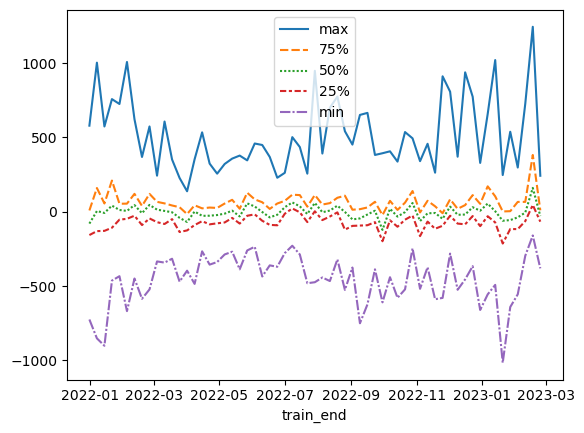

In [40]:
sns.lineplot(predictions.groupby('train_end').describe()['residual'][['max', '75%', '50%', '25%', 'min']])

Plot percentage errors (relative error) quantiles.

<Axes: xlabel='train_end'>

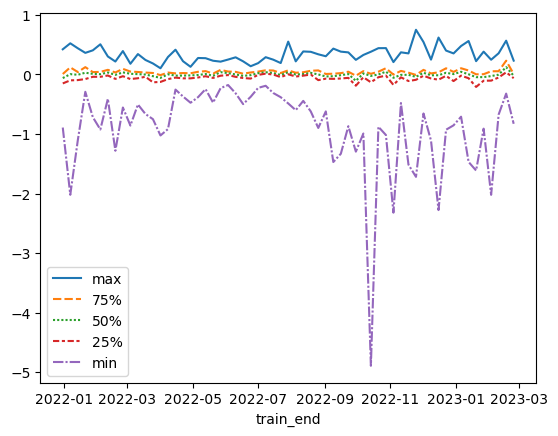

In [41]:
sns.lineplot(predictions.groupby('train_end').describe()['pe'][['max', '75%', '50%', '25%', 'min']])

Plot absolute percentage error quartiles over time/models.

<Axes: xlabel='train_end'>

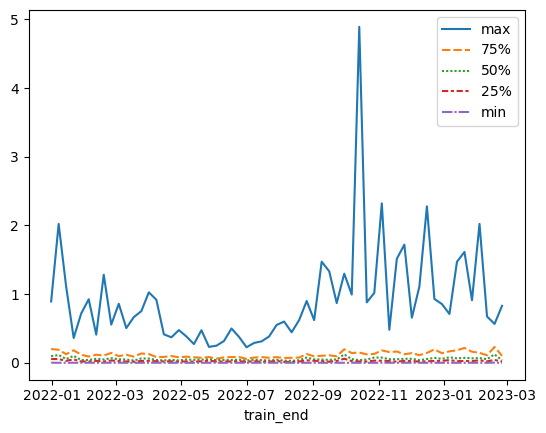

In [42]:
sns.lineplot(predictions.groupby('train_end').describe()['ape'][['max', '75%', '50%', '25%', 'min']])